In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpaches
import matplotlib as mpl
import backtrader as bt 
import yfinance as yf

In [2]:
df = yf.download('BA',start='2021-08-03', end='2022-08-04',progress=False)
google = yf.download('GOOG',start='2021-08-03', end='2022-08-04',progress=False)
ba = yf.download('BA',start='2021-08-03', end='2022-08-04',progress=False)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-02,227.190002,230.470001,224.869995,225.339996,225.339996,8889100
2021-08-03,225.899994,229.100006,221.300003,229.089996,229.089996,7326400
2021-08-04,226.419998,232.350006,225.330002,226.630005,226.630005,9756300
2021-08-05,226.679993,231.539993,226.490005,229.940002,229.940002,8362600
2021-08-06,231.550003,233.570007,230.419998,231.330002,231.330002,6061900


In [3]:
google.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-02,135.484497,136.020493,134.669495,135.989502,135.989502,20140000
2021-08-03,136.000000,136.335495,134.183502,136.279999,136.279999,19064000
2021-08-04,136.249496,136.537994,135.414993,136.028503,136.028503,16528000
2021-08-05,136.028503,136.949997,135.600006,136.940002,136.940002,11866000
2021-08-06,136.294998,137.080048,136.046494,137.035995,137.035995,13560000


In [4]:
ba.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-02,227.190002,230.470001,224.869995,225.339996,225.339996,8889100
2021-08-03,225.899994,229.100006,221.300003,229.089996,229.089996,7326400
2021-08-04,226.419998,232.350006,225.330002,226.630005,226.630005,9756300
2021-08-05,226.679993,231.539993,226.490005,229.940002,229.940002,8362600
2021-08-06,231.550003,233.570007,230.419998,231.330002,231.330002,6061900


In [5]:
df = df.loc[:,['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)# inplace meaning
df['simple_rtn']=df.adj_close.pct_change()# meaning 
df['log_rtn']=np.log(df.adj_close/df.adj_close.shift(1))


In [6]:
df.head

<bound method NDFrame.head of              adj_close  simple_rtn   log_rtn
Date                                        
2021-08-02  225.339996         NaN       NaN
2021-08-03  229.089996    0.016642  0.016505
2021-08-04  226.630005   -0.010738 -0.010796
2021-08-05  229.940002    0.014605  0.014500
2021-08-06  231.330002    0.006045  0.006027
...                ...         ...       ...
2022-07-28  159.089996    0.019220  0.019037
2022-07-29  159.309998    0.001383  0.001382
2022-08-01  169.070007    0.061264  0.059461
2022-08-02  163.279999   -0.034246 -0.034846
2022-08-03  166.639999    0.020578  0.020369

[254 rows x 3 columns]>

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Log return (%)')]

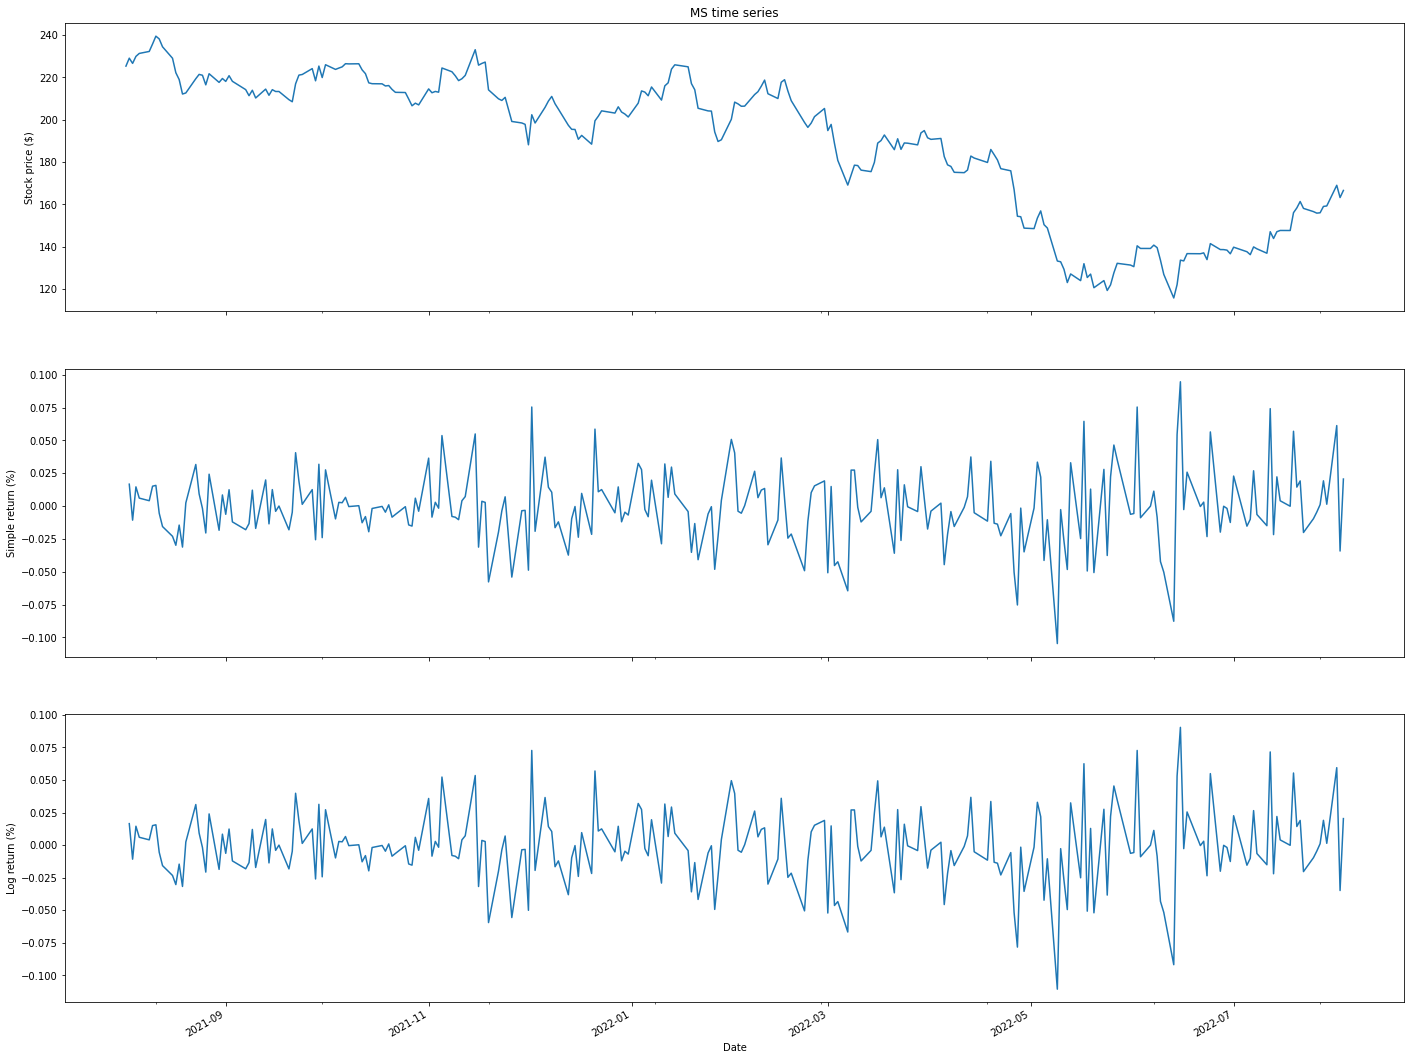

In [7]:
#Following charts present the prices of MS as well as its simple and logarithmic
fig,ax= plt.subplots(3,1 ,figsize=(24,20),sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title='MS time series',ylabel='Stock price ($)')
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Simple return (%)')
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel='Date', ylabel='Log return (%)')

In [8]:
df_rolling = df[['simple_rtn']].rolling(window=22).aggregate(['mean','std'])


df_rolling.columns = df_rolling.columns.droplevel()
df_outliers = df.join(df_rolling)
def indentify_outliers(row, n_sigmas=3) :
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma) :
        return 1
    else:
        return 0 


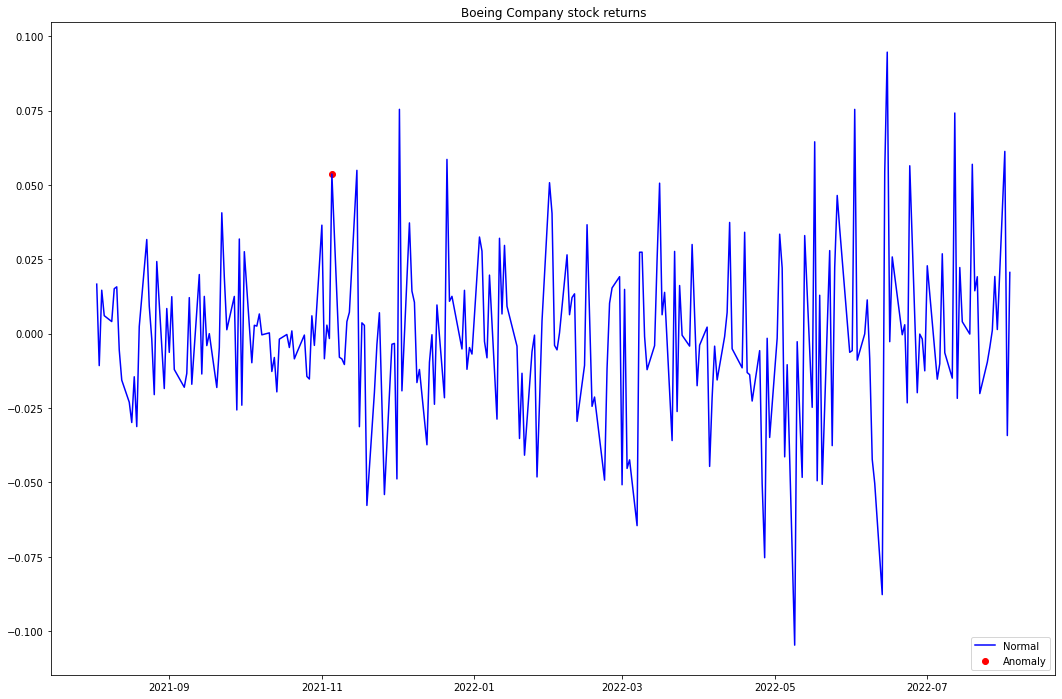

In [9]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,axis=1)
outliers = df_outliers.loc[df_outliers['outlier']==1,['simple_rtn']]

fig, ax = plt.subplots(figsize=(18,12))
ax.plot(df_outliers.index,df_outliers.simple_rtn,color='blue',label='Normal')
ax.scatter(outliers.index,outliers.simple_rtn, color='red',label='Anomaly')
ax.set_title("Boeing Company stock returns")
ax.legend(loc='lower right')

In [10]:
class SmaStrategy (bt.Strategy) :
    params = (('ma_period' , 20),)
    def __init__ (self):
        self.data_close = self.datas[0].close
        self.order = None
        self.price = None
        self.comm = None
        self.sma = bt.ind.SMA(self.datas [0],
                                period=self.params.ma_period)
        

In [11]:
def log(self, txt):
    dt=self.datas [0].datetime.date(0).isoformat()
    print(f'{dt}, {txt}')
    
def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
        return
    
    if order.status in [order.Completed]:
        if order.isbuy():
                    self.log(f'BUY EXECUTED --- Price:{order.executed.price:.2f}')# commision #XX
                    
                             
        else:
            self.log(f' SELL EXECUTED --- Price:{order.executed.price:.2f}')
                     

            self.bar_executed = len(self)
                     
    elif order.status in [order.Canceled,order.Margin,order.Rejected]:
                self.log('Order Fatled')
    self.order=None

In [12]:
def notify_trade(self, trade):
    if not trade.isclosed:
        return
    self.log(f'OPERATION RESULT ---Gross: {trade.pnl:.2f},Net:{trade.pnlcomm:.2f}')
    
def next(self):
    if self.order:
        return
    if not self.position:
        if self.data_close[0] > self.sma[0]:
            self.log(f' BUY CREATED --- Price:{self.data_close[0]:.2f}')
            self.order = self.buy()
    else:
        if self.data_close[0]< self.sma[0]:
                self.log(f' SELL CREATED --- Price:{self.data_close[0]:.2f}')
                self.order = self.sell()

In [13]:
import yfinance as yf
import backtrader as bt

data = bt.feeds.PandasData(dataname=yf.download('BA', '2021-08-03', '2022-08-04'))

cerebro = bt.Cerebro()
cerebro.adddata(data)

[*********************100%***********************]  1 of 1 completed


In [14]:
cerebro =bt.Cerebro(stdstats=False)
cerebro.adddata(data)

In [15]:
cerebro.broker.setcash(10000000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.broker.setcommission(0.001)
cerebro.addsizer(bt.sizers.PercentSizer,percents=10)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [16]:
print (f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')


Starting Portfolio Value: 10000000.00


In [17]:
cerebro.run()


In [18]:
print (f'Starting Portfolio Value')
cerebro. run()
print (f' Final Portfolio Value')

Starting Portfolio Value
 Final Portfolio Value


In [19]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000000.00


In [20]:
cerebro.run()

In [21]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 10000000.00


#Backtesting
from __future__ import (
     absolute_import,
     division,
     print_function,
     unicode_literals,
)

import backtrader as bt
from datetime import datetime
from fastquant.strategies.base import BaseStrategy

class MACDStrategy(BaseStrategy):
    
    params = (
    ("fast_period",12),
    ("slow_period",26),
    ("signal_period",9),
    )

from fastquant.strategies.base import BaseStrategy

#def __init__ (self) :
    super().__init__()

self.fast_period = self.params.fast_period
self.slow_period = self.params.slow_period
self.signal_period = self.params.signal_period
self.commission = self.params.commission

    if self.strategy_logging:
print("===Strategy level arguments===")
print("fast period: ",self.fast_period)
print ("slow period:",self.slow_period)
print ("signal period :",self.signal_period)

    maco_ind = bt.ind.MACD(
        period_me1=self.fast_period,
        period_me2=self.slow_period,
        period_signal=self.signal_period
    


    self.macd = macd_ind.macd
    self.signal =macd_ind.signal
    self.crossover = bt.ind.CrossOver(
        self.macd, self.signal
    )
    
def buy_signal(self):
    return self.crossover> 0

def sell signal(self) :
    return self.crossover < 0

In [22]:
pip install backtesting


Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install bokeh

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install echo

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install backtrader

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install bt

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install ffn 

Note: you may need to restart the kernel to use updated packages.


In [28]:
import ffn

In [29]:
import bt
# fetch some data
data = bt.get('BA', start='2021-08-03', end='2022-08-04')
print(data.head())

                    ba
Date                  
2021-08-03  229.089996
2021-08-04  226.630005
2021-08-05  229.940002
2021-08-06  231.330002
2021-08-09  232.270004


In [30]:
# create the strategy
s = bt.Strategy('s1', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

In [31]:
# create a backtest and run it
test = bt.Backtest(s, data)
res = bt.run(test)

<AxesSubplot:title={'center':'Equity Progression'}>

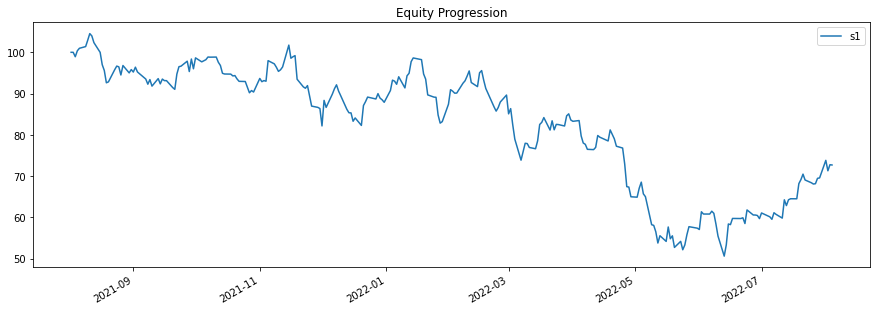

In [32]:
res.plot()

In [33]:
%matplotlib inline


<AxesSubplot:title={'center':'Equity Progression'}>

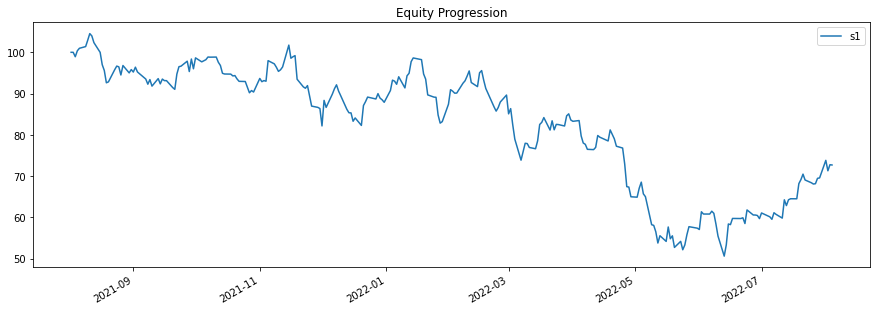

In [34]:
res.plot()

In [35]:
res.display()

Stat                 s1
-------------------  ----------
Start                2021-08-02
End                  2022-08-04
Risk-free rate       0.00%

Total Return         -27.32%
Daily Sharpe         -0.50
Daily Sortino        -0.83
CAGR                 -27.21%
Max Drawdown         -51.62%
Calmar Ratio         -0.53

MTD                  4.51%
3m                   6.07%
6m                   -19.35%
YTD                  -17.30%
1Y                   -26.53%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -27.21%

Daily Sharpe         -0.50
Daily Sortino        -0.83
Daily Mean (ann.)    -21.97%
Daily Vol (ann.)     44.04%
Daily Skew           0.07
Daily Kurt           1.48
Best Day             9.46%
Worst Day            -10.47%

Monthly Sharpe       -0.66
Monthly Sortino      -0.93
Monthly Mean (ann.)  -21.99%
Monthly Vol (ann.)   33.23%
Monthly Skew         -0.36
Monthly Kurt         1.58
Best Month           16.52%
Worst Month          -22.28%

Y

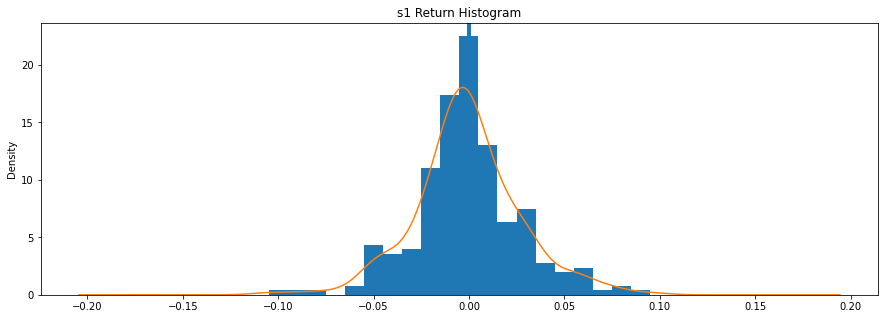

In [36]:
res.plot_histogram()

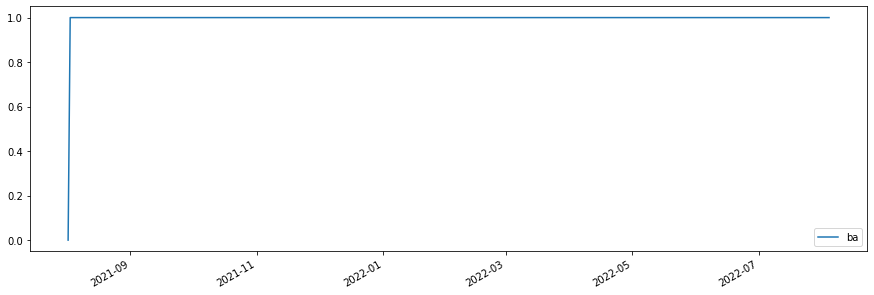

In [37]:
res.plot_security_weights()

In [38]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA,GOOG
# test2 = pd.DataFrame(test)

class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(ba, SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()

bt.plot()

C:\Python310\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Row(id='1450', ...)

In [39]:
pip install ta-lib   # if not working install the .whl file manually with pip install <file>

Note: you may need to restart the kernel to use updated packages.


In [40]:
import numpy
import talib

close = numpy.random.random(100)

In [41]:
output = talib.SMA(close)

In [42]:
from talib import MA_Type

upper, middle, lower = talib.BBANDS(close, matype=MA_Type.T3)

In [43]:
output = talib.MOM(close, timeperiod=5)

In [44]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA

class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(ba, SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

Row(id='2182', ...)

In [45]:


df.tail()

,adj_close,simple_rtn,log_rtn
Date,,,
2022-07-28,159.089996,0.019220,0.019037
2022-07-29,159.309998,0.001383,0.001382
2022-08-01,169.070007,0.061264,0.059461
2022-08-02,163.279999,-0.034246,-0.034846
2022-08-03,166.639999,0.020578,0.020369


In [46]:
import pandas as pd


def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

In [47]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [48]:
%%script echo

    def next(self):
        if (self.sma1[-2] < self.sma2[-2] and
                self.sma1[-1] > self.sma2[-1]):
            self.position.close()
            self.buy()

        elif (self.sma1[-2] > self.sma2[-2] and    # Ugh!
              self.sma1[-1] < self.sma2[-1]):
            self.position.close()
            self.sell()

In [49]:
from backtesting import Backtest

bt = Backtest(ba, SmaCross, cash=10_000, commission=.002)
stats = bt.run()
stats

Start                     2021-08-02 00:00:00
End                       2022-08-03 00:00:00
Duration                    366 days 00:00:00
Exposure Time [%]                   83.858268
Equity Final [$]                  7334.687687
Equity Peak [$]                       10000.0
Return [%]                         -26.653123
Buy & Hold Return [%]              -26.049524
Return (Ann.) [%]                  -26.473886
Volatility (Ann.) [%]               30.055393
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -50.722539
Avg. Drawdown [%]                  -50.722539
Max. Drawdown Duration      309 days 00:00:00
Avg. Drawdown Duration      309 days 00:00:00
# Trades                                   13
Win Rate [%]                        23.076923
Best Trade [%]                       20.75153
Worst Trade [%]                    -13.055861
Avg. Trade [%]                    

In [50]:
bt.plot()

Row(id='2914', ...)

In [51]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)

CPU times: total: 2 s
Wall time: 2.16 s


In [52]:
stats

Start                     2021-08-02 00:00:00
End                       2022-08-03 00:00:00
Duration                    366 days 00:00:00
Exposure Time [%]                   77.559055
Equity Final [$]                 17157.290632
Equity Peak [$]                  17631.531965
Return [%]                          71.572906
Buy & Hold Return [%]              -26.049524
Return (Ann.) [%]                    70.84515
Volatility (Ann.) [%]               57.205436
Sharpe Ratio                         1.238434
Sortino Ratio                         3.65289
Calmar Ratio                         4.698804
Max. Drawdown [%]                  -15.077274
Avg. Drawdown [%]                   -6.064874
Max. Drawdown Duration       68 days 00:00:00
Avg. Drawdown Duration       19 days 00:00:00
# Trades                                    5
Win Rate [%]                            100.0
Best Trade [%]                      31.351087
Worst Trade [%]                      0.294159
Avg. Trade [%]                    

In [53]:
stats._strategy


<Strategy SmaCross(n1=25,n2=50)>

In [54]:
bt.plot(plot_volume=False, plot_pl=False)

Row(id='3523', ...)

In [55]:
stats.tail()

Expectancy [%]                                            12.102688
SQN                                                        2.062282
_strategy                                     SmaCross(n1=25,n2=50)
_equity_curve                       Equity  DrawdownPct Drawdown...
_trades              Size  EntryBar  ExitBar  EntryPrice   ExitP...
dtype: object

In [56]:
stats['_equity_curve'] 

,Equity,DrawdownPct,DrawdownDuration
2021-08-02,10000.000000,0.000000,NaT
2021-08-03,10000.000000,0.000000,NaT
2021-08-04,10000.000000,0.000000,NaT
2021-08-05,10000.000000,0.000000,NaT
2021-08-06,10000.000000,0.000000,NaT
...,...,...,...
2022-07-28,16593.610823,0.014332,NaT
2022-07-29,16616.490950,0.012973,NaT
2022-08-01,17631.531965,0.000000,11 days
2022-08-02,17029.371077,0.034152,NaT


In [57]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,46,57,71,216.973073,219.360001,109.798658,0.011001,2021-10-21,2021-11-10,20 days
1,-46,71,122,218.921281,200.100006,865.778627,0.085973,2021-11-10,2022-01-25,76 days
2,54,122,144,200.500206,201.089996,31.848672,0.002942,2022-01-25,2022-02-25,31 days
3,-54,144,236,200.687816,137.770004,3397.561852,0.313511,2022-02-25,2022-07-11,136 days
4,104,236,253,138.045544,164.509995,2752.302823,0.191708,2022-07-11,2022-08-03,23 days
